In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

## Question 1

There is in fact a singularity in the integral, but neither the integrator used or the quad function care.

//anaconda3/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


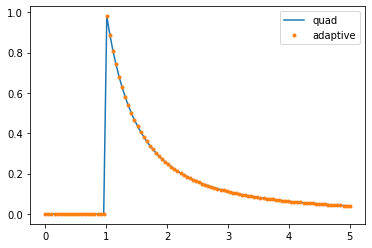

In [2]:
def class_integrate_adaptive(fun,x0,x1,tol):
    # integrate_adaptive function taken from lecture notes
    counter = 0 # set up counter for question 2 since I'll be using this function to compare
    x=np.linspace(x0,x1,5)
    y=fun(x)
    counter += 5
    dx=(x1-x0)/(len(x)-1)
    area1=2*dx*(y[0]+4*y[2]+y[4])/3 #coarse step
    area2=dx*(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/3 #finer step
    err=np.abs(area1-area2)
    if err<tol:
        return area2, counter
    else:
        xmid=(x0+x1)/2
        left, leftcounter=class_integrate_adaptive(fun,x0,xmid,tol/2)
        right, rightcounter=class_integrate_adaptive(fun,xmid,x1,tol/2)
        return left+right, counter + leftcounter + rightcounter

R = 1
sigma = 1
eps = 1

def f(x, z): 
    # the integral we're integrating
    return 1/(2*eps)*(sigma*R**2*np.sin(x)*(z-R*np.cos(x)))*(R**2+z**2-2*R*z*np.cos(x))**(-3/2)

def get_integral(f):
    results1 = []
    results2 = []
    int1 = integrate.quad(f, 0, np.pi)
    int2 = class_integrate_adaptive(f, 0, np.pi, 1e-09)
    results1.append(int1[0])
    results2.append(int2[0])
    results1 = np.array(results1, dtype = object)
    results2 = np.array(results2, dtype = object)
    return np.ndarray.flatten(results1), np.ndarray.flatten(results2)

z = np.linspace(0, 5, 100)

y1 = []
y2 = []
for i in z:
    if i < R:
        y1.append(0)
        y2.append(0)
    else:
        y1.append(get_integral(lambda x: f(x,i))[0])
        y2.append(get_integral(lambda x: f(x,i))[1])
        
plt.plot(z, y1, '-', label = 'quad') # the dots overlap perfectly with the adaptive so I use lines instead
plt.plot(z, y2, '.', label = 'adaptive')
plt.legend()
plt.show()

## Question 2

In [3]:
def integrate_adaptive(fun,x0,x1,tol, extra = None):
    # We use extra to pass function evaluations already ran to the subcalls
    counter = 0 # set up counter to count the number of function evaluations
    if extra is None: # things we only want to run in the first instance
        y0 = fun(x0)
        y1 = fun(x1)
        xmid = (x1+x0)/2
        ymid=fun(xmid)
        counter += 3
    else: # unpacking stuff from previous call
        y0, xmid, ymid, y1 = extra[0], extra[1], extra[2], extra[3]
    
    xleftmid = (x0+xmid)/2
    xrightmid = (xmid+x1)/2
    yleftmid = fun(xleftmid)
    yrightmid = fun(xrightmid)
    counter += 2
    
    area = (x1-x0)/6 * (y0+4*ymid+y1)
    leftarea = (xmid-x0)/6 * (y0+4*yleftmid+ymid)
    rightarea = (x1-xmid)/6 * (ymid+4*yrightmid+y1)
    area2 = leftarea + rightarea
    err=np.abs(area-area2)
    if err<tol:
        return area2, counter
    else:
        left, leftcounter = integrate_adaptive(fun,x0,xmid,tol/2, extra = (y0, xleftmid, yleftmid, ymid))
        right, rightcounter = integrate_adaptive(fun,xmid,x1,tol/2, extra = (ymid, xrightmid, yrightmid, y1))
        return left+right, counter + leftcounter + rightcounter

In [4]:
def poly(x):
    return x**5

print('We save', class_integrate_adaptive(poly, 0, 1, 1e-9)[1]-integrate_adaptive(poly, 0, 1, 1e-9)[1], \
      'function calls evaluating x^5 from 0 to 1 at 1e-9 threshold')
print('We save', class_integrate_adaptive(np.sin, 0, 1, 1e-9)[1]-integrate_adaptive(np.sin, 0, 1, 1e-9)[1], \
      'function calls evaluating sin(x) from 0 to 1 at 1e-9 threshold')

We save 594 function calls evaluating x^5 from 0 to 1 at 1e-9 threshold
We save 168 function calls evaluating sin(x) from 0 to 1 at 1e-9 threshold


## Question 3

Following the question we scale (0.5, 1) to (-1, 1) for the fit. Since the 7th coefficient of the fit was on the order e-7, we take only the first 7 coefficients. We break down x-values using np.frexp(x) to get the mantissa which has values between (0.5, 1) and exponent values which are over base 2. We apply the same scaling as we did in the original fit on the mantissa values and apply simple log laws to get natural log from log base 2.
<br>
$ln(x) = \frac{log_2(x)}{log_2(e)}$ and $log_2(mantissa \times 2^{exp}) = log_2(mantissa) + exp$

In [5]:
def mylog2(x):
    xx = np.linspace(0.5,1,100)
    x_scaled = np.interp(xx, (0.5, 1), (-1, +1))
    fit = np.polynomial.chebyshev.chebfit(x_scaled, np.log2(xx), 20)
    mantx, expx = np.frexp(x)
    mante, expe = np.frexp(np.e)
    mantx_scaled = np.interp(mantx, (0.5, 1), (-1, +1))
    mante_scaled = np.interp(mante, (0.5, 1), (-1, +1))
    log2x = np.polynomial.chebyshev.chebval(mantx_scaled, fit[0:8]) + expx
    log2e = np.polynomial.chebyshev.chebval(mante_scaled, fit[0:8]) + expe
    return log2x/log2e

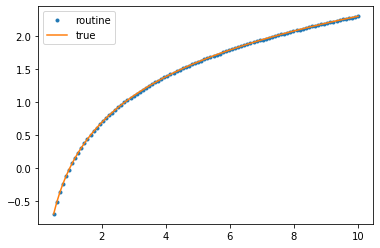

[ 1.49991163e-07  3.88751956e-08 -6.72177591e-08  1.28208733e-08
 -2.56156381e-08 -1.66395732e-07 -2.62733351e-08  1.77178199e-07
 -1.42729716e-07 -5.85444734e-08  2.04373047e-07  1.38277594e-07
 -1.00513109e-07 -1.73447665e-08  2.30927553e-07 -4.96902404e-08
 -5.25957923e-08 -2.12291557e-08  2.48247324e-07  2.73076831e-07
  1.13606630e-07 -4.94739734e-08 -9.72865042e-08 -1.55655527e-08
  1.32717175e-07  2.59172378e-07  2.97848379e-07  2.33665895e-07
  1.05757820e-07 -1.25020065e-08 -4.92587859e-08  2.62486886e-08
  1.75754218e-07  2.93868663e-07  2.60195371e-07  6.37660165e-08
  2.33015665e-08  8.54963267e-08 -7.12647055e-08  1.88213654e-08
  1.74404892e-07  3.01123041e-07  3.61710456e-07  3.53756349e-07
  2.93603812e-07  2.05132310e-07  1.12370731e-07  3.50628830e-08
 -1.35446698e-08 -2.72965799e-08 -6.60112986e-09  4.28143963e-08
  1.11539927e-07  1.88253104e-07  2.61425581e-07  3.20817625e-07
  3.58657712e-07  3.70442380e-07  3.55325123e-07  3.16092538e-07
  2.58751636e-07  1.91774

In [7]:
x = np.linspace(0.5, 10, 100)
plt.plot(x, mylog2(x), '.', label = 'routine')
plt.plot(x, np.log(x), '-', label = 'true')
plt.legend()
plt.show()
print(mylog2(x)-np.log(x))